# Preperations


## Imports


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ast
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from upsetplot import plot as upsetplot

from src.consts import PATHS

## Constants

In [3]:
base_output_dir = PATHS.PROJECT_DIR / "output"

In [4]:
from src.consts import FILTERATIONS
from src.datasets.download_dataset import load_dataset, load_splitted_counter_fact
from src.types import DATASETS, DatasetArgs

In [5]:
df = load_dataset(DatasetArgs(name=DATASETS.COUNTER_FACT, splits="all"))

In [6]:
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_colwidth", 100)

## Loading Data

### Load Known Files Pre-processed Evaluations
#

In [50]:
correct_files_raw = {
    experiment_path.name.replace("minimal_", ""): pd.read_csv(known_1000_correct_file, index_col=0).reset_index(
        drop=True
    )
    for experiment_path in base_output_dir.glob("**")
    if (known_1000_correct_file := experiment_path / "evaluate" / "counter_fact.csv").exists()
    and "mamba" in experiment_path.name.lower()
    # and 'falcon' not in experiment_path.name.lower()
}

print(correct_files_raw.keys())

dict_keys(['mamba-130M-hf', 'mamba-2.8B-hf', 'mamba2-2.7B', 'mamba2-130M', 'mamba2-1.3b', 'mamba-1.4B-hf', 'falcon-mamba-7b', 'Falcon3-Mamba-7B-Base', 'mamba-7b-rw'])


### Preprocess Data

In [51]:
def remove_generation_prefix(df):
    # For some models, the generation is prefixed with the prompt
    return df.apply(
        lambda x: x["model_generation"].removeprefix(
            x["prompt"],
        ),
        axis=1,
    )


def is_correct(target, prediction) -> bool:
    return len(prediction.strip()) > 0 and target.strip().startswith(prediction.strip())


def fix_model_correct(df):
    # Make sure that model_output is at least 1 character long; if empty, it's incorrect
    return df.apply(
        lambda x: is_correct(x["attribute"], x["model_output"]),
        axis=1,
    )


def split_top_outputs(df):
    df = df.copy()
    COL = "model_top_outputs"
    for i in range(len(df[COL].iloc[0])):
        df[f"pred_token_{i + 1}"] = df[COL].apply(lambda x: [item[0] for item in x]).apply(lambda x: x[i])
        df[f"pred_{i + 1}"] = df[COL].apply(lambda x: [item[1] for item in x]).apply(lambda x: x[i])
        df[f"confidence_{i + 1}"] = df[COL].apply(lambda x: [item[2] for item in x]).apply(lambda x: x[i])

    return df.drop(columns=COL)


def correct_output_position(df):
    preds = df.pipe(split_top_outputs)
    preds["correct_position"] = np.inf
    for i in range(1, 6):
        preds["correct_position"] = preds.apply(
            lambda x: (
                min(x["correct_position"], i) if is_correct(x["attribute"], x[f"pred_{i}"]) else x["correct_position"]
            ),
            axis=1,
        )
    return preds["correct_position"]


def confidence_correct(df):
    preds = df.pipe(split_top_outputs)

    return preds.apply(
        lambda x: np.inf if x["correct_position"] > 5 else x[f"confidence_{int(x['correct_position'])}"],
        axis=1,
    )


def confidence_diff(df):
    preds = df.pipe(split_top_outputs)

    return preds.apply(
        lambda x: np.inf
        if x["correct_position"] > 5
        else x["confidence_1"] - x[f"confidence_{int(x['correct_position'])}"],
        axis=1,
    )


correct_files = {
    experiment_name: (
        df.pipe(lambda df: df.head(len(df) - 1))
        .assign(
            **{
                "model_output": lambda df: df["model_output"].fillna(""),
                "model_top_outputs": lambda df: df["model_top_outputs"].apply(ast.literal_eval),
            }
        )
        .assign(
            **{
                "model_generation": remove_generation_prefix,
                # "model_correct": fix_model_correct,
                # "correct_position": correct_output_position,
                "correct_position": lambda df: df["target_rank"],
                "confidence_correct": confidence_correct,
                "confidence_diff": confidence_diff,
            }
        )
        .assign(
            **{
                # "any_correct": lambda df: df["correct_position"] != np.inf,
                "any_correct": lambda df: df["target_rank"] <= 5,
            }
        )
    )
    for experiment_name, df in sorted(correct_files_raw.items())
}

In [52]:
model_names = list(correct_files.keys())
model_names

['Falcon3-Mamba-7B-Base',
 'falcon-mamba-7b',
 'mamba-1.4B-hf',
 'mamba-130M-hf',
 'mamba-2.8B-hf',
 'mamba-7b-rw',
 'mamba2-1.3b',
 'mamba2-130M',
 'mamba2-2.7B']

In [53]:
# Show keys of the files
print(correct_files[next(iter(correct_files))].keys())
print(correct_files.keys())

Index(['relation', 'relation_prefix', 'relation_suffix', 'prompt',
       'relation_id', 'attribute', 'subject', 'original_idx', 'split',
       'model_correct', 'model_top_output_confidence', 'target_rank',
       'model_top_outputs', 'model_generation', 'target_probs',
       'target_tokens', 'model_output', 'correct_position',
       'confidence_correct', 'confidence_diff', 'any_correct'],
      dtype='object')
dict_keys(['Falcon3-Mamba-7B-Base', 'falcon-mamba-7b', 'mamba-1.4B-hf', 'mamba-130M-hf', 'mamba-2.8B-hf', 'mamba-7b-rw', 'mamba2-1.3b', 'mamba2-130M', 'mamba2-2.7B'])


In [54]:
# Sort known_1000_correct_files by experiment name
per_model_stats_dict = []

# Print experiment details in a hierarchical format
current_arch = None
for model_id, df in correct_files.items():
    df_any_correct = df[df["any_correct"]]
    df_correct = df[df["model_correct"]]
    df_any_correct_but_not_first = df[(df["any_correct"]) & (~df["model_correct"])]
    position_value_counts = df_any_correct["correct_position"].value_counts() / len(df)
    per_model_stats_dict.append(
        {
            "model_id": model_id,
            "accuracy": f"{df['model_correct'].mean():.2%}",
            "accuracy_any_correct": f"{df['any_correct'].mean():.2%}",
            "mean_target_rank": f"{df['target_rank'].mean():.2f}",
            "mean_confidence_model_correct": f"{df_correct['model_top_output_confidence'].mean():.2f}",
            "mean_top_confidence_model_any_correct": f"{df_any_correct['model_top_output_confidence'].mean():.2f}",
            "mean_correct_confidence_model_any_correct": f"{df_any_correct['confidence_correct'].mean():.2f}",
            "mean_correct_confidence_model_correct_but_not_first": f"{df_any_correct_but_not_first['confidence_correct'].mean():.2f}",
            "mean_confidence_diff_model_any_correct_but_not_first": f"{df_any_correct_but_not_first['confidence_diff'].mean():.2f}",
            "mean_confidence_diff": f"{df_any_correct['confidence_diff'].mean(): .2f}",
            "mean_correct_position": f"{df_any_correct['correct_position'].mean():.2f}",
            "mean_correct_top_output_confidence": f"{df_any_correct['model_top_output_confidence'].mean():.2f}",
            **{
                f"correct_position_{int(position)}": f"{count:.2%}" for position, count in position_value_counts.items()
            },
        }
    )

per_model_stats_df = pd.DataFrame(per_model_stats_dict)
per_model_stats_df

,model_id,accuracy,accuracy_any_correct,mean_target_rank,mean_confidence_model_correct,mean_top_confidence_model_any_correct,mean_correct_confidence_model_any_correct,mean_correct_confidence_model_correct_but_not_first,mean_confidence_diff_model_any_correct_but_not_first,mean_confidence_diff,mean_correct_position,mean_correct_top_output_confidence,correct_position_1,correct_position_2,correct_position_3,correct_position_4,correct_position_5
0,Falcon3-Mamba-7B-Base,16.57%,38.67%,525.83,0.44,0.40,0.23,0.08,0.30,0.17,2.20,0.40,16.57%,8.62%,5.96%,4.27%,3.25%
1,falcon-mamba-7b,19.62%,44.76%,389.28,0.47,0.42,0.25,0.08,0.30,0.17,2.17,0.42,19.62%,10.02%,6.67%,4.81%,3.63%
2,mamba-1.4B-hf,15.39%,35.52%,450.02,0.37,0.33,0.20,0.07,0.22,0.13,2.16,0.33,15.39%,8.29%,5.22%,3.87%,2.74%
3,mamba-130M-hf,7.90%,23.91%,859.28,0.27,0.25,0.12,0.05,0.18,0.12,2.36,0.25,7.90%,6.52%,4.47%,2.96%,2.07%
4,mamba-2.8B-hf,17.26%,37.90%,394.77,0.41,0.36,0.23,0.07,0.24,0.13,2.12,0.36,17.26%,8.46%,5.57%,3.65%,2.97%
5,mamba-7b-rw,23.40%,48.18%,227.17,0.46,0.40,0.26,0.08,0.26,0.13,2.04,0.40,23.40%,10.55%,6.48%,4.43%,3.32%
6,mamba2-1.3b,15.32%,36.02%,436.04,0.38,0.33,0.20,0.07,0.22,0.13,2.17,0.33,15.32%,8.94%,5.09%,3.79%,2.89%
7,mamba2-130M,7.95%,22.75%,839.53,0.31,0.27,0.15,0.06,0.19,0.12,2.37,0.27,7.95%,5.89%,3.76%,2.91%,2.24%
8,mamba2-2.7B,15.96%,37.70%,390.72,0.40,0.34,0.21,0.07,0.23,0.13,2.18,0.34,15.96%,9.17%,5.32%,4.15%,3.11%


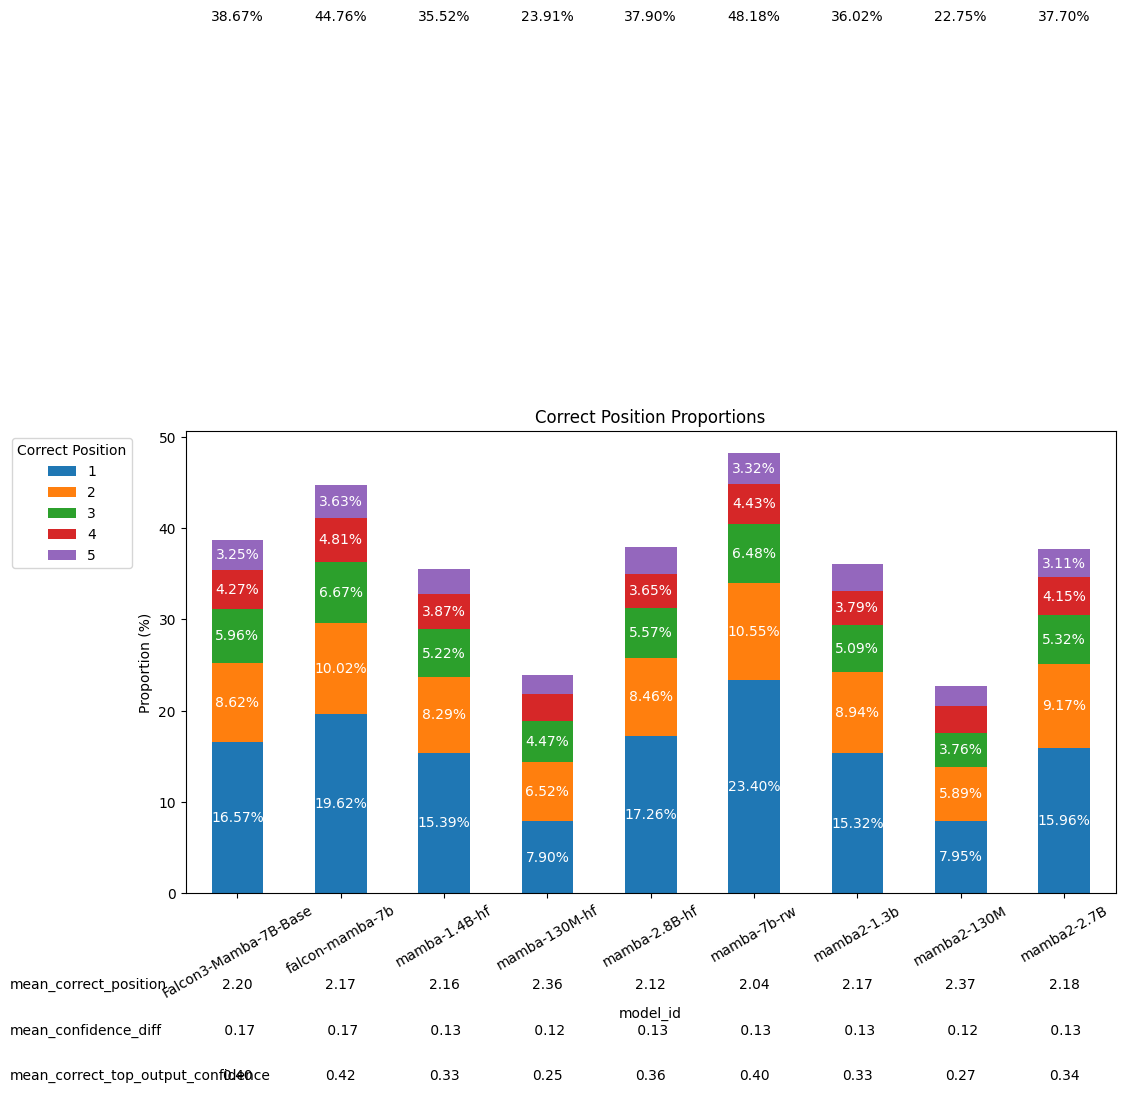

In [55]:
def plot_correct_position_proportions(
    df,
    additional_info_cols=[
        "mean_correct_position",
        "mean_confidence_diff",
        "mean_correct_top_output_confidence",
    ],
):
    rename_col = lambda col: col.replace("correct_position_", "")
    correct_position_cols = [col for col in df.columns if col.startswith("correct_position_")]

    correct_position_df = df.assign(
        **{rename_col(col): df[col].apply(lambda x: float(x.rstrip("%"))) for col in correct_position_cols}
    ).melt(
        id_vars=["model_id"],
        value_vars=map(rename_col, correct_position_cols),
        var_name="correct_position",
        value_name="proportion",
    )

    # Pivot the data to make it suitable for a stacked bar plot
    pivot_df = correct_position_df.pivot_table(index=["model_id"], columns="correct_position", values="proportion")

    # Plotting the stacked bar plot
    ax = pivot_df.plot(kind="bar", stacked=True, figsize=(12, 6))
    plt.title("Correct Position Proportions")

    plt.ylabel("Proportion (%)")
    plt.xticks(rotation=30)
    plt.legend(title="Correct Position", bbox_to_anchor=(-0.05, 1), loc="upper right")

    n_bars = len(pivot_df)
    height = {i: 0 for i in range(n_bars)}
    # Adding total amount on top of each bar
    for idx, bar in enumerate(ax.patches):
        bar_i = idx % n_bars
        position_i = idx // n_bars
        if bar.get_height() > 3:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height[bar_i] + bar.get_height() / 2,
                f"{pivot_df.iloc[bar_i, position_i]:.2f}%",
                fontsize=10,
                ha="center",
                va="center",
                color="white",
            )

        height[bar_i] += bar.get_height()

    for i, col in enumerate(additional_info_cols):
        ax.text(
            -2.2,
            -10 - i * 5,
            col,
            fontsize=10,
            ha="left",
            va="center",
            color="black",
        )

    # Adding summary on each model
    for i in range(n_bars):
        bar_location = ax.patches[i].get_x() + ax.patches[i].get_width() / 2
        model_stats = df.iloc[i]

        ax.text(
            bar_location,
            96,
            model_stats["accuracy_any_correct"],
            fontsize=10,
            ha="center",
            va="center",
            color="black",
        )

        for j, col in enumerate(additional_info_cols):
            ax.text(
                bar_location,
                -10 - j * 5,
                model_stats[col],
                fontsize=10,
                ha="center",
                va="center",
                color="black",
            )

    # plt.tight_layout()
    plt.show()


plot_correct_position_proportions(per_model_stats_df)

## Combining Data
#

In [56]:
correct_files.keys()

dict_keys(['Falcon3-Mamba-7B-Base', 'falcon-mamba-7b', 'mamba-1.4B-hf', 'mamba-130M-hf', 'mamba-2.8B-hf', 'mamba-7b-rw', 'mamba2-1.3b', 'mamba2-130M', 'mamba2-2.7B'])

In [57]:
# Predefined constants for column names
INDEX_COL = "original_idx"
TOTAL_CORRECT_COL = "total_correct"
AGGREEMENT_TYPE_COL = "agreement_type"
MODEL_CORRECT_COL = "model_correct"
INDEX_COLUMNS = ["model_id"]
PER_MODEL_COLS = [
    MODEL_CORRECT_COL,
    "model_output",
    "model_top_output_confidence",
    "model_generation",
    "model_top_outputs",
    "correct_position",
    "confidence_diff",
    "any_correct",
    "target_rank",
    "target_probs",
    "target_tokens",
    "target_first_tokens",
    "confidence_correct",
    "split",
]
SHARE_COLS = [col for col in df.columns if col not in PER_MODEL_COLS + [INDEX_COL]]

# Processing the data using pipes
result = (
    pd.concat([df.assign(**{INDEX_COLUMNS[0]: name}) for name, df in correct_files.items()])
    .set_index(INDEX_COL)
    .pipe(
        lambda df: (
            pd.concat(
                [
                    df[PER_MODEL_COLS + INDEX_COLUMNS].set_index(INDEX_COLUMNS[0], append=True).unstack(level=[-1]),
                    df[SHARE_COLS].drop_duplicates().sort_index(),
                ],
                axis=1,
            )
        )
    )
    .pipe(
        lambda df: df.assign(
            **{
                TOTAL_CORRECT_COL: df[[col for col in df.columns if col[0] == MODEL_CORRECT_COL]].sum(axis=1),
                "total_any_correct": df[[col for col in df.columns if col[0] == "any_correct"]].sum(axis=1),
                AGGREEMENT_TYPE_COL: (
                    df[[col for col in df.columns if col[0] == MODEL_CORRECT_COL]]
                    .astype(int)
                    .apply(lambda x: "".join(x.astype(str)), axis=1)
                ),
                "any_correct_agreement_type": (
                    df[[col for col in df.columns if col[0] == "any_correct"]]
                    .astype(int)
                    .apply(lambda x: "".join(x.astype(str)), axis=1)
                ),
            }
        )
    )
)

# Experiments

## Experiment 1 - Value Counts

### Experiment 1.1 - Value Counts for Total Correct

In [58]:
# Print value counts for total_correct
(result[TOTAL_CORRECT_COL].value_counts(normalize=True).map(lambda x: f"{x:.2%}"))

total_correct
0    67.36%
1     7.94%
2     4.27%
7     3.47%
3     3.13%
9     3.06%
6     2.98%
4     2.72%
5     2.58%
8     2.50%
Name: proportion, dtype: object

In [59]:
# Print value counts for total_correct
(result["total_any_correct"].value_counts(normalize=True).map(lambda x: f"{x:.2%}"))

total_any_correct
0    37.21%
9    13.77%
1    10.42%
2     7.38%
7     6.68%
8     5.77%
3     5.46%
6     4.62%
5     4.48%
4     4.21%
Name: proportion, dtype: object

### Experiment 1.2 - Agreement Type Value Counts
#
In this experiment, we will look at the value counts of the agreement types.
Agreement type is a string that encodes which models agreed on a correct prediction.
#

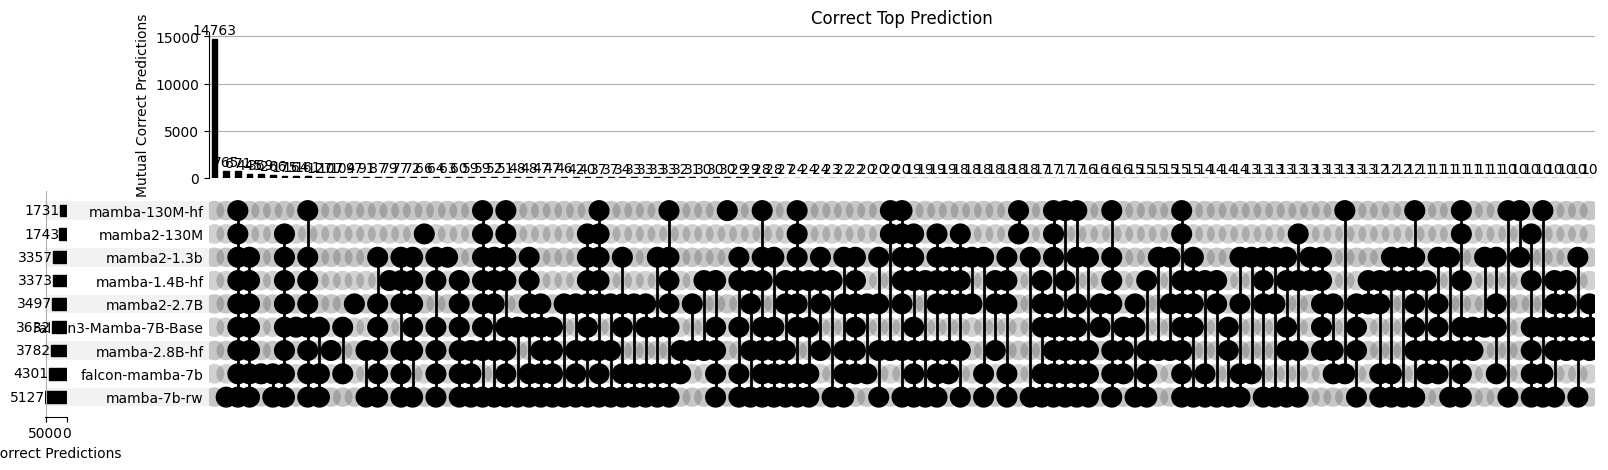

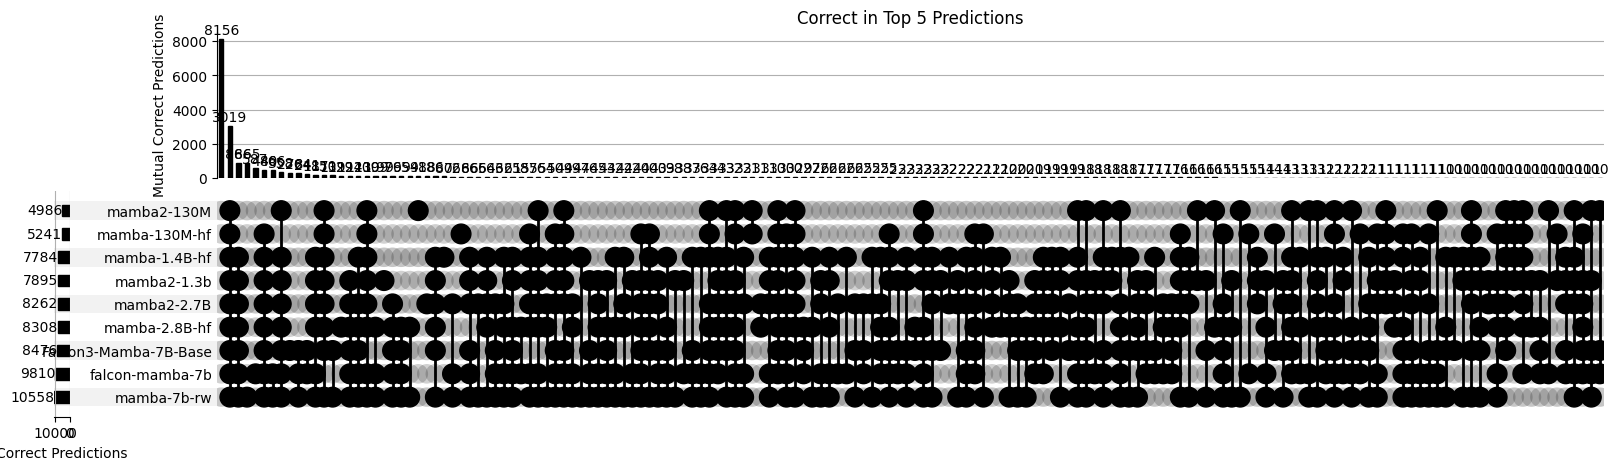

In [60]:
def plot_upset(result, agreement_type_col, title, min_subset_size=10):
    res = (
        result[agreement_type_col]
        .reset_index()
        .assign(
            **{
                model: lambda df, model=model, i=i: result[agreement_type_col].str[i] == "1"
                for i, model in enumerate(model_names)
            }
        )
        .groupby(model_names)["original_idx"]
        .count()
    )

    fig = plt.figure(figsize=(20, 5))

    upset = upsetplot(
        res,
        fig=fig,
        orientation="horizontal",
        sort_by="cardinality",
        facecolor="black",
        show_counts=True,
        min_subset_size=min_subset_size,
        element_size=None,
    )

    upset["intersections"].set_ylabel("Mutual Correct Predictions")
    upset["totals"].set_xlabel("Correct Predictions")

    plt.title(title)
    plt.show()


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot_upset(result, AGGREEMENT_TYPE_COL, "Correct Top Prediction")
    plot_upset(result, "any_correct_agreement_type", "Correct in Top 5 Predictions")

### Save filterations

In [61]:
PATHS.COUNTER_FACT_FILTERATIONS_DIR.mkdir(parents=True, exist_ok=True)

total_correct_filteration = result.pipe(lambda df: df[df["total_correct"] == len(model_names)]).reset_index()[
    "original_idx"
]
any_correct_filteration = result.pipe(lambda df: df[df["total_any_correct"] == len(model_names)]).reset_index()[
    "original_idx"
]

print(f"Total correct filteration: {len(total_correct_filteration)}")
print(f"Any correct filteration: {len(any_correct_filteration)}")

total_correct_filteration.to_csv(PATHS.COUNTER_FACT_FILTERATIONS_DIR / f"{FILTERATIONS.all_correct}.csv", index=False)
any_correct_filteration.to_csv(PATHS.COUNTER_FACT_FILTERATIONS_DIR / f"{FILTERATIONS.all_any_correct}.csv", index=False)

Total correct filteration: 671
Any correct filteration: 3019


In [62]:
len(model_names)

9

In [63]:
total_correct_filteration.loc[[0, 1, 2]]

0    53
1    59
2    74
Name: original_idx, dtype: int64

### check distribution of splits

In [64]:
for filteration in [FILTERATIONS.all_correct, FILTERATIONS.all_any_correct]:
    print(filteration)
    display(
        pd.DataFrame(
            load_splitted_counter_fact("all", add_split_name_column=True, filteration=filteration)
        ).value_counts("split_name")
    )

all_correct


Filter:   0%|          | 0/21919 [00:00<?, ? examples/s]

split_name
test      328
train4     70
train5     70
train3     69
train2     68
train1     66
Name: count, dtype: int64

all_any_correct


Filter:   0%|          | 0/21919 [00:00<?, ? examples/s]

split_name
test      1522
train1     315
train4     306
train5     306
train3     292
train2     278
Name: count, dtype: int64

### Examples of Agreement Type Mistakes
#

In [65]:
agreement_type_example = "1110000"
i_example = 2

# example = result[result[AGGREEMENT_TYPE_COL] == agreement_type_example].iloc[[i_example]]
example = result[result["any_correct_agreement_type"] == agreement_type_example].iloc[[i_example]]


indexed_columns = [col for col in example.columns if isinstance(col, tuple)]

# Print shared_columns
display(example.drop(columns=indexed_columns))

print("-" * 50)

(
    example[indexed_columns]
    .melt(var_name="variable", value_name="value")
    .assign(
        col=lambda df_: df_["variable"].apply(lambda x: x[0]),
        arch_name=lambda df_: df_["variable"].apply(lambda x: x[1]),
        size=lambda df_: df_["variable"].apply(lambda x: x[2]),
    )
    .drop(columns=["variable"])
    .pivot(index=INDEX_COLUMNS, columns="col", values="value")
    .drop(columns=["model_output", "model_top_output_confidence"])
    .pipe(split_top_outputs)
)

IndexError: positional indexers are out-of-bounds

## Experiment 2 - Relation ID Interactions
#
### Value Counts for Relation ID
#

In [ ]:
# Value counts for relation_id
result["relation_id"].value_counts().tail(10)

relation_id
P39     476
P127    433
P140    430
P108    350
P641    318
P138    279
P407    216
P463    163
P36     139
P264     53
Name: count, dtype: int64

### Aggregated Statistics for Relation ID
#

In [ ]:
# Aggregated statistics for relation_id
# Only keep relation_ids that appear at least 25 times, then get top 100 per id
top_relation_ids = (
    result.pipe(lambda df: df[df["relation_id"].map(df["relation_id"].value_counts()) >= 25])
    .groupby("relation_id")[AGGREEMENT_TYPE_COL]
    .value_counts()
    .groupby(level=0)
    .head(100)
    .unstack(level=0)
)

# Display aggregated statistics
display(top_relation_ids)

relation_id,P101,P103,P106,P108,P127,P1303,P131,P136,P138,P140,P1412,P159,P17,P176,P178,P19,P190,P20,P264,P27,P276,P30,P36,P364,P37,P39,P407,P413,P449,P463,P495,P641,P740,P937
agreement_type,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00000000,484.0,466.0,777.0,266.0,325.0,345.0,625.0,809.0,244.0,218.0,876.0,252.0,694.0,103.0,78.0,663.0,608.0,703.0,53.0,369.0,453.0,700.0,43.0,347.0,484.0,452.0,131.0,871.0,514.0,134.0,801.0,207.0,717.0,716.0
10000000,12.0,6.0,2.0,4.0,5.0,13.0,15.0,9.0,1.0,11.0,4.0,13.0,8.0,5.0,13.0,3.0,2.0,6.0,NaN,13.0,12.0,10.0,4.0,8.0,1.0,6.0,4.0,9.0,2.0,NaN,2.0,4.0,NaN,5.0
01000000,10.0,2.0,17.0,10.0,9.0,21.0,13.0,22.0,18.0,20.0,21.0,83.0,13.0,17.0,21.0,27.0,NaN,8.0,NaN,61.0,34.0,9.0,7.0,78.0,8.0,5.0,16.0,14.0,32.0,6.0,14.0,6.0,1.0,12.0
11000000,5.0,6.0,9.0,4.0,1.0,8.0,5.0,2.0,NaN,8.0,1.0,38.0,1.0,NaN,9.0,5.0,NaN,6.0,NaN,31.0,8.0,5.0,12.0,28.0,6.0,3.0,5.0,1.0,9.0,NaN,3.0,3.0,NaN,9.0
00000001,4.0,NaN,2.0,4.0,9.0,2.0,2.0,NaN,NaN,4.0,NaN,4.0,1.0,5.0,4.0,12.0,4.0,4.0,NaN,15.0,3.0,15.0,2.0,9.0,4.0,NaN,2.0,NaN,13.0,1.0,9.0,NaN,8.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10110101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
10110001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
00010110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


### Visualizing - Heatmap of Relation IDs
#

ValueError: Unknown format code 'd' for object of type 'float'

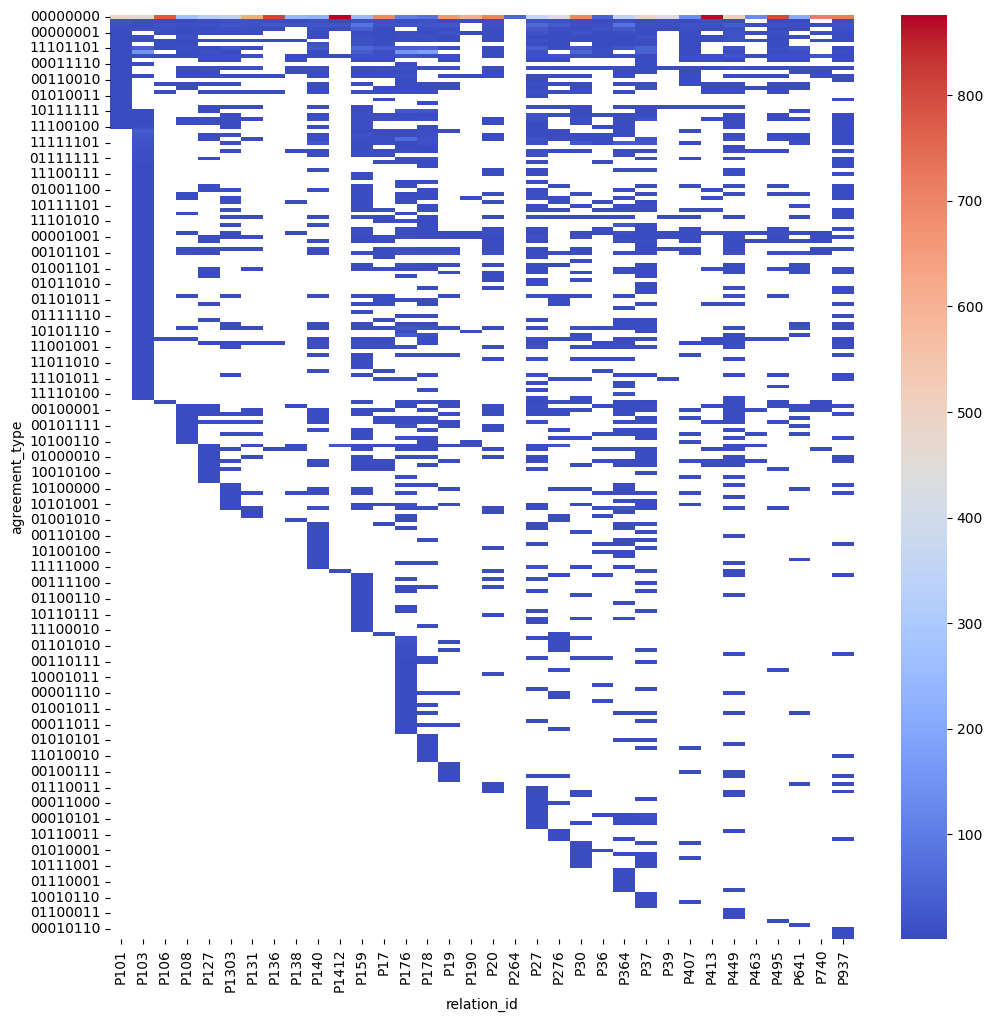

In [ ]:
plt.figure(figsize=(12, 12))
sns.heatmap(top_relation_ids, annot=True, fmt="d", cmap="coolwarm")
plt.title("Top 100 Correct Predictions per Relation ID")
plt.show()